# Task 1, Getting the data from kaggle and running the notebook

In [149]:
! if [ ! -d ~/.kaggle ]; then mkdir ~/.kaggle; fi
! echo '{"username":"spencerclarke","key":"5bb26d8ebba2ac95f40e589c61f63ce7"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d eminserkanerdonmez/ais-dataset
! if [ -f ais_data.csv ]; then rm ais_data.csv; fi
! unzip ais-dataset.zip

ais-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ais-dataset.zip
  inflating: ais_data.csv            


# Task 2


## Task 2A
A decision tree alone would not be a good choice for this problem. In order to be effective, a single tree has to have a large depth which can lead to issues such as overfitting. If the decision boundary created by a split in the decision tree contains mostly outliers, then any new data that falls into that decision boundary is likely to receive an absurd prediction (that the predicted variable will have a similar value to the outliers). A better idea would be to use gradient boosting, in which a model is created by one decision tree and then another decision tree is trained on the error of the first one's prediction, and then the new model is created by subtracting the predicted error from the prediction. Another option, which is even more resistant to overfitting, is random forests, in which many decision trees with a low depth are created and trained on different parts of the data, and their predictions are averaged together, or in the case of classification, they are treated as voters and the classification with the most votes is the final prediction.


## Task 2B
This notebook uses the random forest classifier from Scikit using its default settings, so we must analyze Scikit's defaults. To do so, I have moused over it in VS Code to view its defaults. 

![Screenshot](image1.png)

As we can see, it uses Gini impurity by default. To find the Gini impurity of some collection of data in a classification problem, we iterate over all the classifications, and for each one, we take the probability that a randomly selected datum in the collection is in that classification, square it, and them add it to the sum. We take the sum of all of these for each class, and subtract the sum from 1, which is then the Gini impurity of the data, and acts as a measure of how certain we are that a datum in the collection of data belongs to one class. Gini impurity can therefore be described using the equation 

$G = 1 -\sum_{k=1}^{n}{(\frac{C(k)}{D})^2}$

Where the collection of data has $n$ classes, $D$ data points total, and $C(k)$ is the number of data points that belong to class $k$. The way the random forest classifier is using this is basically splitting nodes such that their child nodes have the lowest Gini impurity to build the decision trees.


# Task 3

## Task 3A
CV stands for cross-validation. It is a technique we can use to detect issues such as overfitting. Overfitting can be tricky to detect because when a model overfits, it performs very well on the data that it was trained on, but performs poorly on new data. Cross-validation detects it by reserving a partition of the data to train the model on, and another partition to test it on. If the model overfits, it is likely to perform poorly on the testing data. This process can be repeated on different partitionings of training data and testing data.

## Task 3B
To include bootstrapping, I have modified the notebook to create a second testing dataset by sampling from the data with replacement (bootstrapping), and tested the models on this new data alongside the cross-validation. The results were that the prediction on the resampled data was much more accurate than with cross-valdiation. This is to be expected as the resampled data contains data that are present in the training data, just with resampling. For this reason it would seem that cross-validation is more useful for detecting issues such as overfitting.

## Task 4
This notebook uses the element of the Scikit RandomForestClassifier, "feature_importances_".

![Screenshot](image2.png)

Since this uses a one-liner to some Scikit thing, we must once again examine Scikit's default behavior. To do so, I have obtained the source code for Scikit's computation for feature importance by each decision tree, written in Cython. This source code is from their public GitHub repository, and is available here.
https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/tree/_tree.pyx

```python
    cpdef compute_feature_importances(self, normalize=True):
        """Computes the importance of each feature (aka variable)."""
        cdef Node* left
        cdef Node* right
        cdef Node* nodes = self.nodes
        cdef Node* node = nodes
        cdef Node* end_node = node + self.node_count

        cdef float64_t normalizer = 0.

        cdef cnp.float64_t[:] importances = np.zeros(self.n_features)

        with nogil:
            while node != end_node:
                if node.left_child != _TREE_LEAF:
                    # ... and node.right_child != _TREE_LEAF:
                    left = &nodes[node.left_child]
                    right = &nodes[node.right_child]

                    importances[node.feature] += (
                        node.weighted_n_node_samples * node.impurity -
                        left.weighted_n_node_samples * left.impurity -
                        right.weighted_n_node_samples * right.impurity)
                node += 1

        for i in range(self.n_features):
            importances[i] /= nodes[0].weighted_n_node_samples

        if normalize:
            normalizer = np.sum(importances)

            if normalizer > 0.0:
                # Avoid dividing by zero (e.g., when root is pure)
                for i in range(self.n_features):
                    importances[i] /= normalizer

        return np.asarray(importances)
```

By looking at the while loop, we can see that to calculate the feature importance of each feature, we look at all the nodes that split on that feature, and for each one we take the Gini impurity of all the data in the node itself weighted by the number of data the node has, and subtract the gini impurities of the data in the left and right nodes after the split, each weighted by the number of data they have. This way, we assign the feature importance to be the sum of the amount of impurity we lost by splitting on the feature. After this we do some normalization, and return feature importances as an array. Essentially, a feature's importance depends on how much Gini impurity it was responsible for eliminating when we split on it. In the case of a random forest of decision trees, it is certain that we are taking these values from each decision tree and then averaging them to obtain the feature importance from the random forest classifier.

# Task 5

## Task 5a and 5b: lightGBM and Optuna
I created a gradient boosting model using lightgbm, its creation can be seen if you scroll down or ctrl + f and search "lightgbm".
Overall, this gradient boosting model delivered impressive performance. I tuned this model using Optuna, and tuned the hyperparameters max_depth and n_estimators. max_depth is an upper limit on the depth of each decision tree, and n_estimators controls how many decision trees are created in the model. I have plotted max_depth, n_estimators, and the accuracy of the model as a 3D plot.


![Screenshot](image3.png)


The model with tuned hyperparameters yielded with an accuracy of about 0.85 on the serving data after tuning hyperparameters max_depth and n_estimators with Optuna. The notebook, on the otherhand, built a tuned random forest model which yielded an accuracy of about 0.63 on the same serving data when I ran it. From this we can deduce that the author's conclusion was incorrect, and that gradient boosting fits this problem better as a model. 

Have I made a mistake and butchered the author's work and slandered him as a man of science without provocation, and in doing so condemned myself to an abyssmal grade? Or have I fulfilled the goal which I set for myself, and uncovered the TRUTH, and revealed that he jumped to conclusions by picking random forests as the best model through benchmark tests on untuned models, and as a result ended with an inferior classification model? I do not know.

In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
import numpy as np
from typing import Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import time
import umap
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb



# Set style for the plots
sns.set(style='darkgrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

df = pd.read_csv('ais_data.csv')
display(df.head())
display(df.tail())

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
358346,387577,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2
358347,387578,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9
358348,387579,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9
358349,387580,219007697,Unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN
358350,387581,261054050,Under way using engine,11.5,315.0,310.0,Fishing,8.0,32.0,6.0


We can drop first column as it is clear it was created when resetting index, or saving csv without removing it. 

In [151]:
df = df.iloc[:,1:]

In [152]:
df.drop(['mmsi'], axis=1).describe()

,sog,cog,heading,width,length,draught
count,357893.000000,355182.000000,337737.000000,354640.000000,354608.000000,332808.000000
mean,12.122554,189.064529,190.076829,19.947854,124.971549,6.571402
std,9.355851,107.588825,107.107604,10.808627,71.268183,2.934392
min,0.000000,0.000000,0.000000,1.000000,2.000000,0.400000
25%,9.200000,116.300000,120.000000,12.000000,83.000000,4.600000
50%,11.300000,168.700000,170.000000,17.000000,115.000000,6.100000
75%,13.300000,300.175000,303.000000,28.000000,181.000000,7.900000
max,214.000000,359.900000,507.000000,78.000000,690.000000,25.500000


Above table shows that their are some clear outliers with sog, length and draught

Having both width and length allows us to add an additional variable (area), with the only caveat being that the length and width were likely taken at the maximum points

In [153]:
df['area'] = df.width * df.length

## Missing values

In [154]:
pd.DataFrame(df.isna().sum())

,0
mmsi,0
navigationalstatus,0
sog,458
cog,3169
heading,20614
shiptype,0
width,3711
length,3743
draught,25543
area,3773


In [155]:
print(f"Proportion of null value rows: {round(len(df[df.isnull().any(axis=1)]) / len(df)*100)}%")

Proportion of null value rows: 9%


Null values account for approximately 9% of the data. A high proportion of missing values in the static variables. So, providing we have this information for the same vessels from another journey, then we should be able to imput these values.

In [156]:
static_vars = ['length', 'width', 'draught', 'area']

for var in static_vars:
    df[var] = df[['mmsi', var]].groupby('mmsi').transform(lambda x: x.fillna(x.median()))

With this imputation, we have been able to fill a good amount of the ships dimensions variables.

We should also include navigational status Unknown values within this as these have been logged as a string opposed to null values. Although we may not remove them, it is good to understand the quantity.


In [157]:
pd.DataFrame(df.navigationalstatus.value_counts())

,count
navigationalstatus,
Under way using engine,307581
Unknown value,17259
Constrained by her draught,12287
Engaged in fishing,10798
Moored,4121
Reserved for future amendment [HSC],1872
Restricted maneuverability,1868
Under way sailing,1396
At anchor,513


In [158]:
# Check to see how the missing values are split between the ship types as a proportion.
missing_ship_count = pd.DataFrame(df[df.isnull().any(axis=1)].shiptype.value_counts()).reset_index()
ship_count = pd.DataFrame(df.shiptype.value_counts()).reset_index()

missing_ship_count = missing_ship_count.merge(ship_count, on='shiptype', how='left')
missing_ship_count['count_after_dropping'] = missing_ship_count.count_y - missing_ship_count.count_x
missing_ship_count['proportion_missing'] = missing_ship_count.count_x/missing_ship_count.count_y

missing_ship_count = missing_ship_count.rename(columns={'count_x':'count_null', 'count_y': 'count'})

missing_ship_count.sort_values(by='proportion_missing', ascending=False)

,shiptype,count_null,count,count_after_dropping,proportion_missing
1,Pleasure,4461,4538,77,0.983032
3,Sailing,2392,2549,157,0.938407
2,SAR,3841,4349,508,0.883192
10,Port tender,259,312,53,0.830128
0,Fishing,13360,25481,12121,0.524312
5,Pilot,1145,4047,2902,0.282926
11,Reserved,184,823,639,0.223572
6,Military,1122,7239,6117,0.154994
14,Towing,147,1034,887,0.142166
13,Law enforcement,171,1688,1517,0.101303


Based on the above table, we may consider dropping ship types Pleasure and Port tender due to having both high proportion missing as well as a limited number of data points once null values would be removed. It is also noted that this would be further reduced when considering both cross validation as well as removing a proportion of these to be used in a serving set for secondary validation. If we chose to keep these variables, it will be important to mention the caveat that predictions made on these ship types should be treat with caution due to limited number of data points.

It is also noted that there is a significant imbalance in the classes, therefore this will need to be considered when choosing the performance metric as well as traiing the model(s)

In [159]:
# Drop nulls
df = df.dropna()

## Checking duplicates

In [160]:
print(f"Number of rows with identical values in all variables: {len(df[df.duplicated()])}")

Number of rows with identical values in all variables: 2904


Quite a high proportion of duplicate rows. Are these duplicates or just different ships with identical values?

In [161]:
Quite a high proportion of duplicate rows. Are these duplicates or just different ships with identical values?

Object `values` not found.


In [162]:
display(df[df.duplicated(keep='first')].sort_values(by=list(df.columns)))

pd.DataFrame(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).shiptype.value_counts())

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
71351,205688000,Under way using engine,9.8,221.0,220.0,Cargo,12.0,83.0,5.0,996.0
227087,205770000,Under way using engine,14.0,34.0,34.0,Tanker,17.0,97.0,5.1,1649.0
128138,209114000,Moored,0.0,291.6,282.0,Cargo,12.0,89.0,4.3,1068.0
255843,209114000,Under way using engine,7.0,165.1,163.0,Cargo,12.0,89.0,4.6,1068.0
116931,209114000,Under way using engine,8.2,325.1,325.0,Cargo,12.0,89.0,4.3,1068.0
...,...,...,...,...,...,...,...,...,...,...
1429,664288000,Under way using engine,15.3,340.0,340.0,Tanker,28.0,185.0,10.5,5180.0
32543,664445000,Under way using engine,12.3,34.5,35.0,Tanker,32.0,189.0,9.5,6048.0
33530,664445000,Under way using engine,12.5,339.4,339.0,Tanker,32.0,189.0,9.5,6048.0
184528,664445000,Under way using engine,14.0,24.5,25.0,Tanker,32.0,189.0,10.7,6048.0


,count
shiptype,
Cargo,3025
Tanker,1894
Passenger,311
Tug,100
Dredging,97
Military,74
HSC,69
SAR,38
Fishing,22


Nothing jumps out with regards to certain variables being able to explain these duplications. 
In case this are actual duplications opposed to similar ships, these are removed from the data to avoid falsely inflating the accuracy of the model(s).

In [163]:
df = df.drop_duplicates()

In [164]:
len(df)

324561

# Exploratory Data Analysis

In [165]:
print(f"Number of unique vessels: {df.mmsi.nunique()}")

Number of unique vessels: 2799


Although we have a large number of rows, the actual number of unique vessels is 2799. For the modelling, we have 2 choices:
- Group by mmsi and then create aggregated variables, or
- Use grouped k fold when validating (ensuring that the same mmsi id is not in both train and test)

We can test which option will be the most appropriate by seeing if the dynamic variables vary much for each vessel (mmsi)

In [166]:
dynamic_vars = ['mmsi', 'sog', 'cog', 'heading']

df[dynamic_vars].groupby('mmsi').agg(
    sog_std = ('sog', 'std'),
    cog_std = ('cog', 'std'),
    heading_std = ('heading', 'std'),
).dropna()

,sog_std,cog_std,heading_std
mmsi,,,
205104000,1.785275,110.797995,110.102214
205209000,2.267307,120.775293,119.890407
205211000,2.554713,119.040468,119.216727
205212000,2.896524,117.348181,121.299998
205465000,1.545513,116.815861,130.592347
...,...,...,...
657246900,1.208701,52.226815,46.098415
664288000,1.316891,123.733167,123.701049
664444000,1.496389,113.060527,113.282904


We can see from the above table that there is variation and therefore we should choose the second option (keep all the rows and use grouped k fold) and have the model learn from this higher resolution data. However, the model training process will take signficantly longer due to the large number of data points.

## Analysis into the outliers

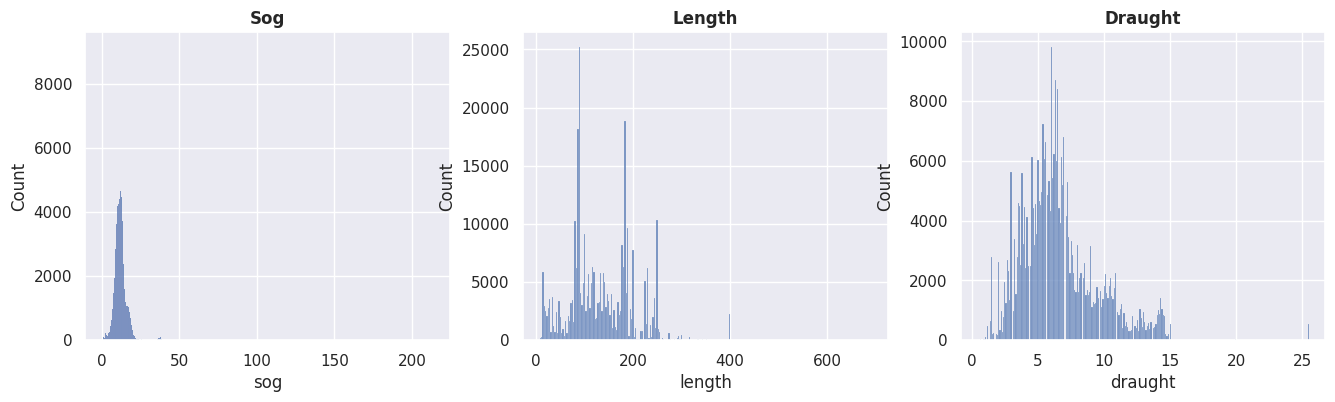

In [167]:
outlier_cols = ['sog', 'length', 'draught']

fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, col in enumerate(outlier_cols):
    ax1 = sns.histplot(df[col], ax=axes[i])
    ax1.set_title(col.capitalize(), weight='bold')


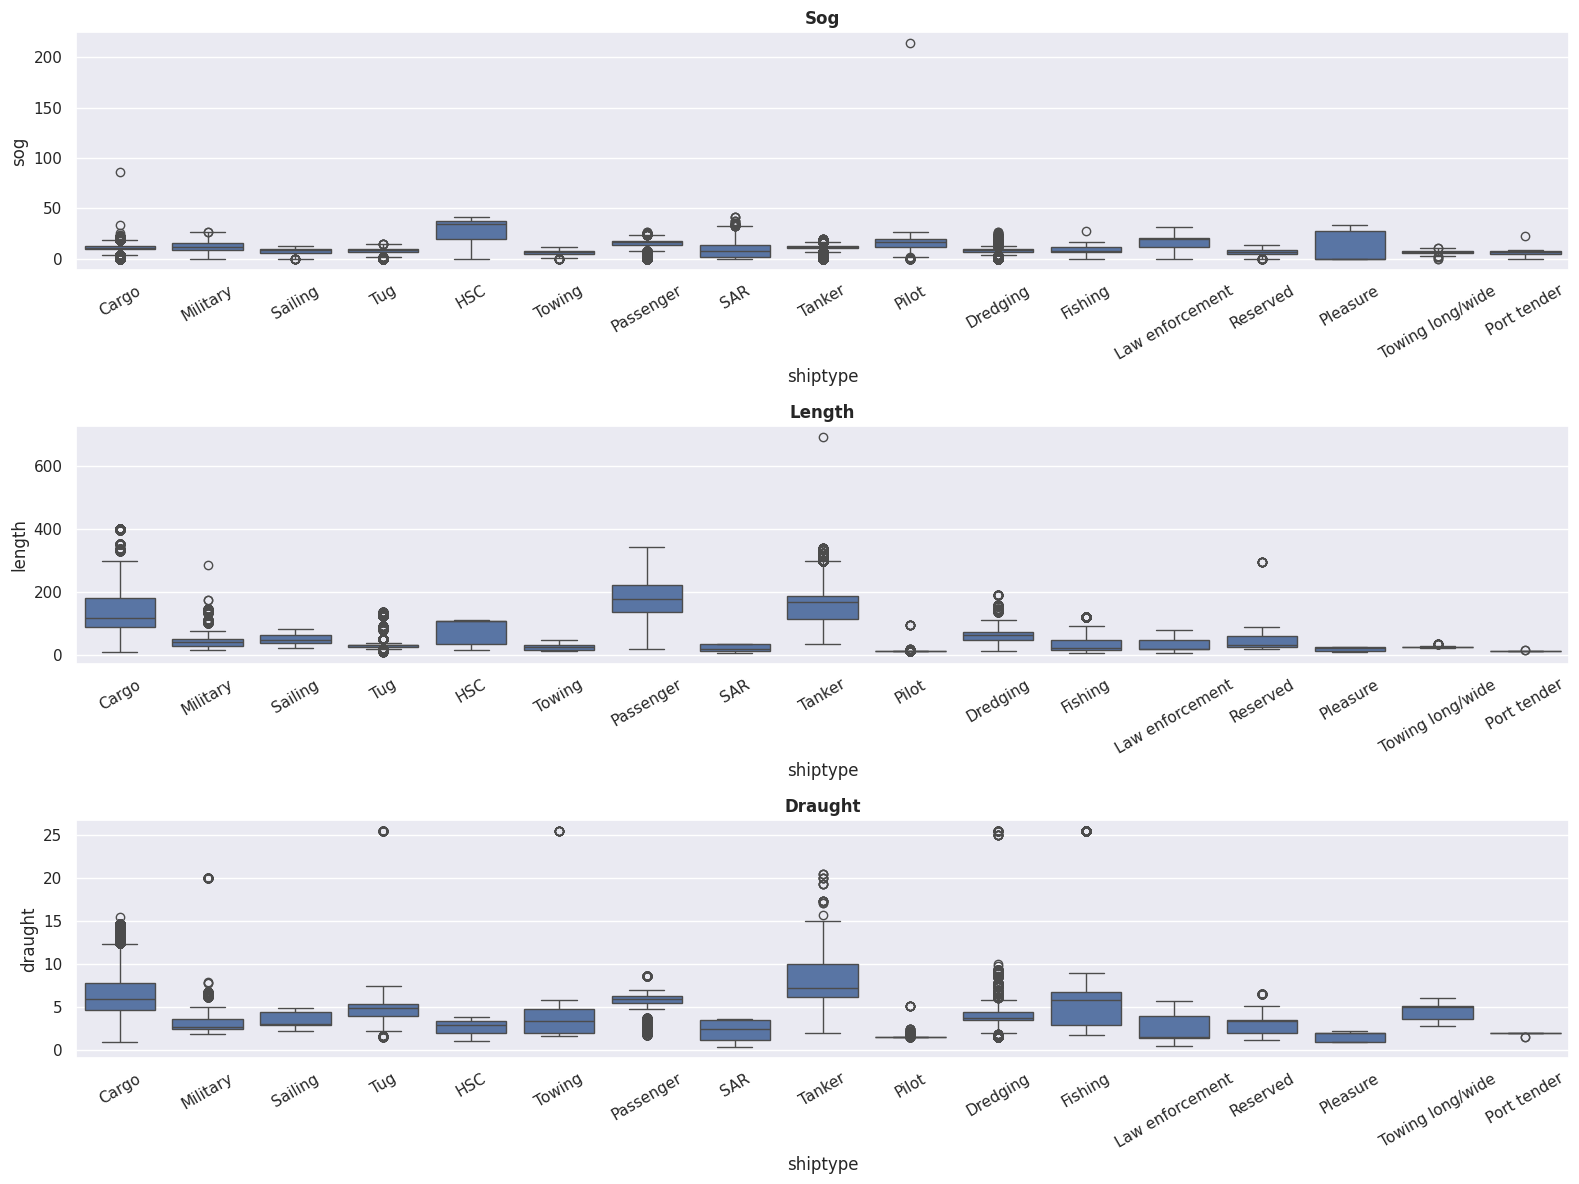

In [168]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [169]:
# Potential rows to remove
df[(df.sog>200)|(df.length>500)]

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
76551,211422510,Under way using engine,13.9,134.5,133.0,Tanker,28.0,690.0,6.8,19320.0
330195,219023648,Under way using engine,214.0,343.7,356.0,Pilot,5.0,15.0,1.5,75.0


Above boxplots illustrates some major outliers in each of the 3 variables.

One of the (what appears to be) obvious errors would be the Pilot ship type having a speed over ground of over 200 knots. In addition to this, assuming the units are in metres, then the tanker length of 690 appears to be an error. Research suggests that the largest tanker made was ~458m.

Based on my limited knowledge of the maritime industry, it would be difficult to conclude what are errors and what are genuine values. The former would result in noise added to the model. However, some models, such as ensemble methods are more robust against outliers.

The decision was made to drop values of length >500 and sog> 200. 

It is also noted that, there are some key differences in the distribution of these variable values between the ship types suggesting that they will have a significant impact in the model performance.

In [170]:
df = df[(df.sog<=200)|(df.length<=500)]

Redo the above plot with adjusted y limit in order to visualise better

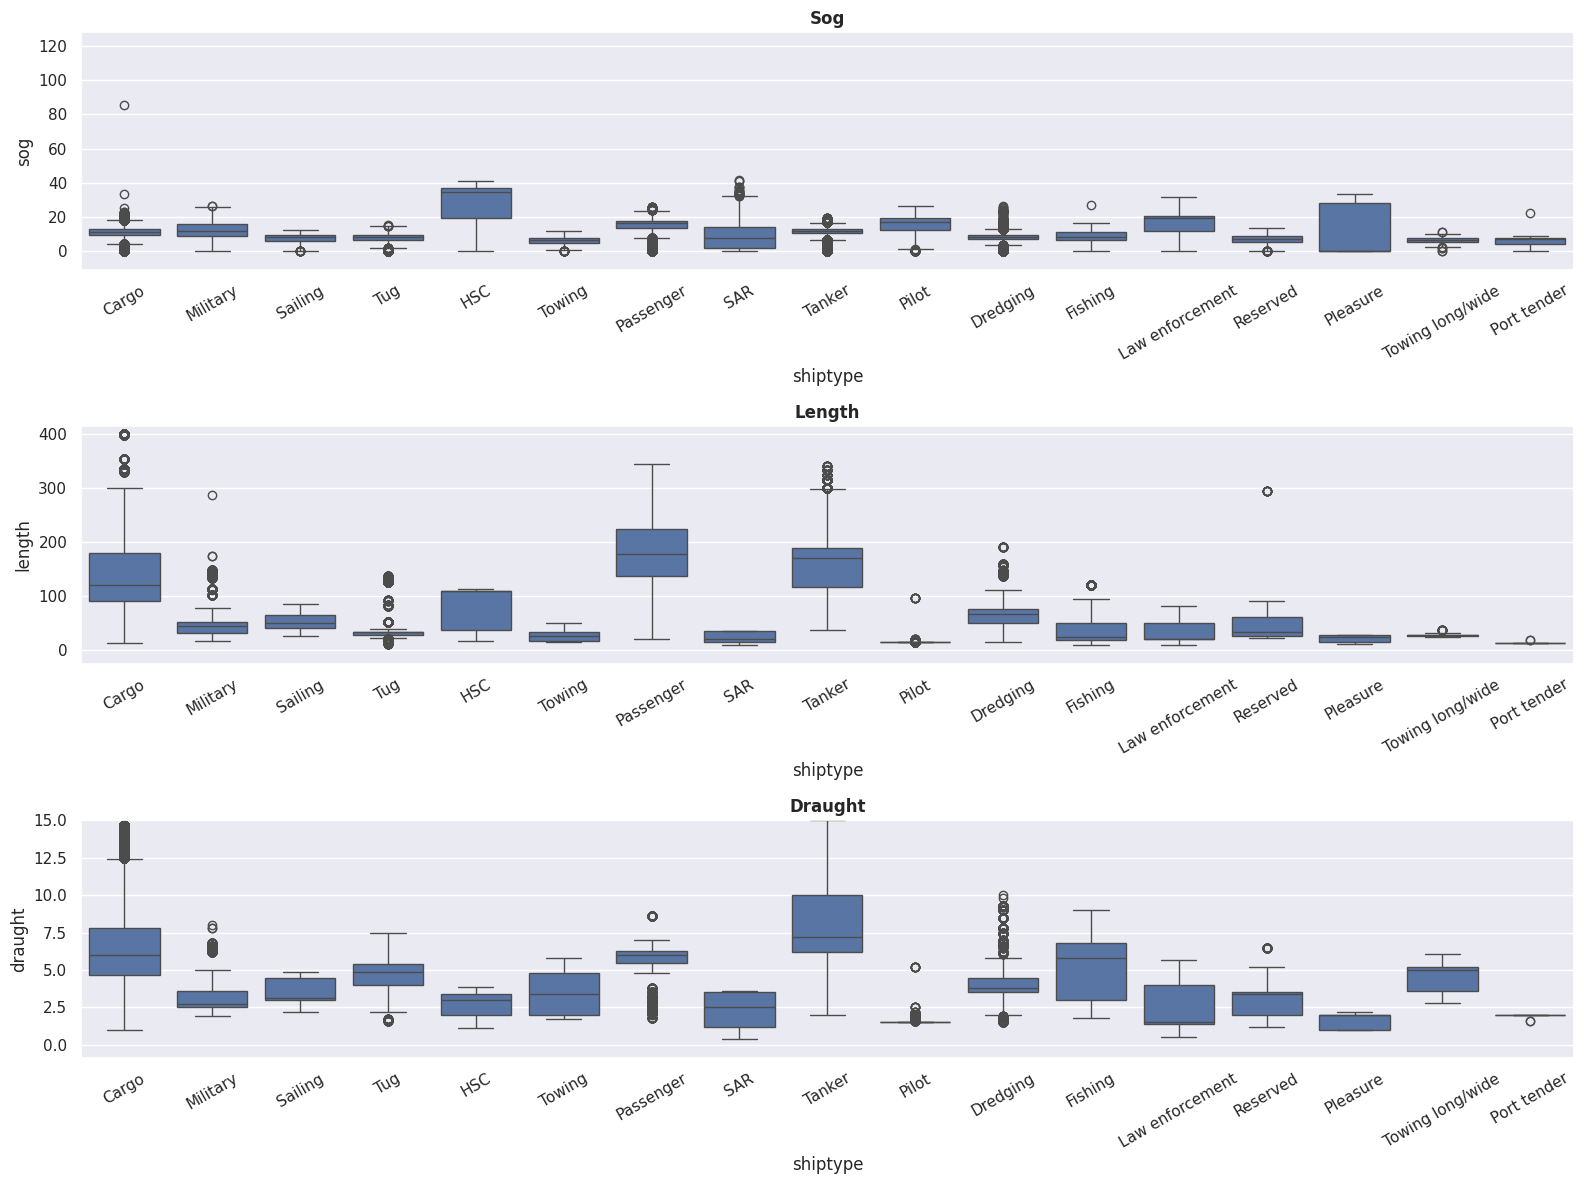

In [171]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    ax.set_ylim(top=int(df[col].max()*.6))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

Now that the y axis has been adjusted we can clearly see the variation between ships for each of the variables. Observations are as follows:
- Sog: Without suprise, the HSB has the highest values
- Length: We can see that length appears to be a clear idendentifier of shiptype, especially in the larger ones such as Cargo, Passenger, and Tanker.
- Draught: Again, some clear variations between shiptypes with Carco, Passenger, and Tankr having the higher values

## Check distribution of shiptypes by navigational status

There is only one column (navigational status) that is of a categorical data type and therefore needs to be encoded (likely one-hot encoding). As there are 13 unique values, it is important to check if there is enough representation of ship types between these groups, as well as seeing if we can see any trends within them.

In [172]:
pd.DataFrame(df.groupby(['navigationalstatus', 'shiptype']).size()).head(60)

0
navigationalstatus                                 shiptype              
At anchor                                          Cargo              227
                                                   Dredging             9
                                                   Fishing              7
                                                   Law enforcement      1
                                                   Military             7
                                                   Reserved            24
                                                   SAR                  1
                                                   Tanker             212
                                                   Towing              14
                                                   Tug                  5
Constrained by her draught                         Cargo             5228
                                                   Dredging            27
                                                   Reserved            25
                                                   Tanker            6779
Engaged in fishing                                 Dredging             1
                                                   Fishing           5370
Moored                                             Cargo             1087
                                                   Dredging            88
                                                   Fishing            148
                                                   HSC                138
                                                   Law enforcement     21
                                                   Military           412
                                                   Passenger          221
                                                   Pilot               92
                                                   Pleasure            46
                                                   Port tender         52
                                                   Reserved            51
                                                   SAR                125
                                                   Sailing             14
                                                   Tanker             362
                                                   Towing              30
                                                   Towing long/wide     2
                                                   Tug                333
Not under command                                  Cargo                1
                                                   Military             1
                                                   Passenger            1
                                                   Tanker               1
                                                   Tug                  1
Power-driven vessel pushing ahead or towing alo... Cargo                1
                                                   Tug                234
Power-driven vessel towing astern                  Tug                246
Reserved for future amendment [HSC]                Fishing             87
                                                   HSC               1644
Restricted maneuverability                         Cargo                6
                                                   Dredging           181
                                                   Law enforcement     12
                                                   Military            18
                                                   Pilot                4
                                                   Reserved            72
                                                   SAR                  1
                                                   Towing             290
                                                   Towing long/wide   340
                                                   Tug                743
Un

Given more time, I would like to understand some of these status values in a bit more detail to see if any should be taken out of the model process and handled separately. The main one of concern would be the unknown value, which accounts for 17259 of the rows. Do we want the model(s) to learn from this or do we risk incorporating noise? Again, due to my limited expertise in the subject matter, the decision was made to leave it in.

## Analysis into the remaining variables

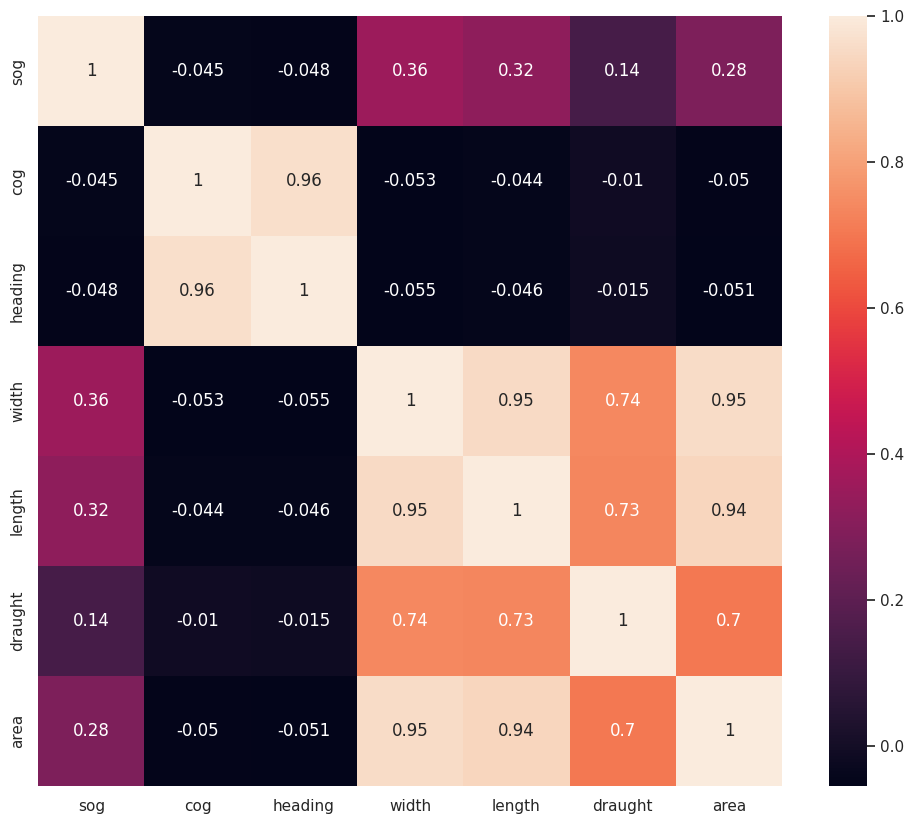

In [173]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()[1:]

plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr(), annot=True)
plt.show()

Some strong (yet unsurprising) correlations between the continuous variables, notably:
- Length, width, and area
- Draught against width, length and area
- Cog and heading

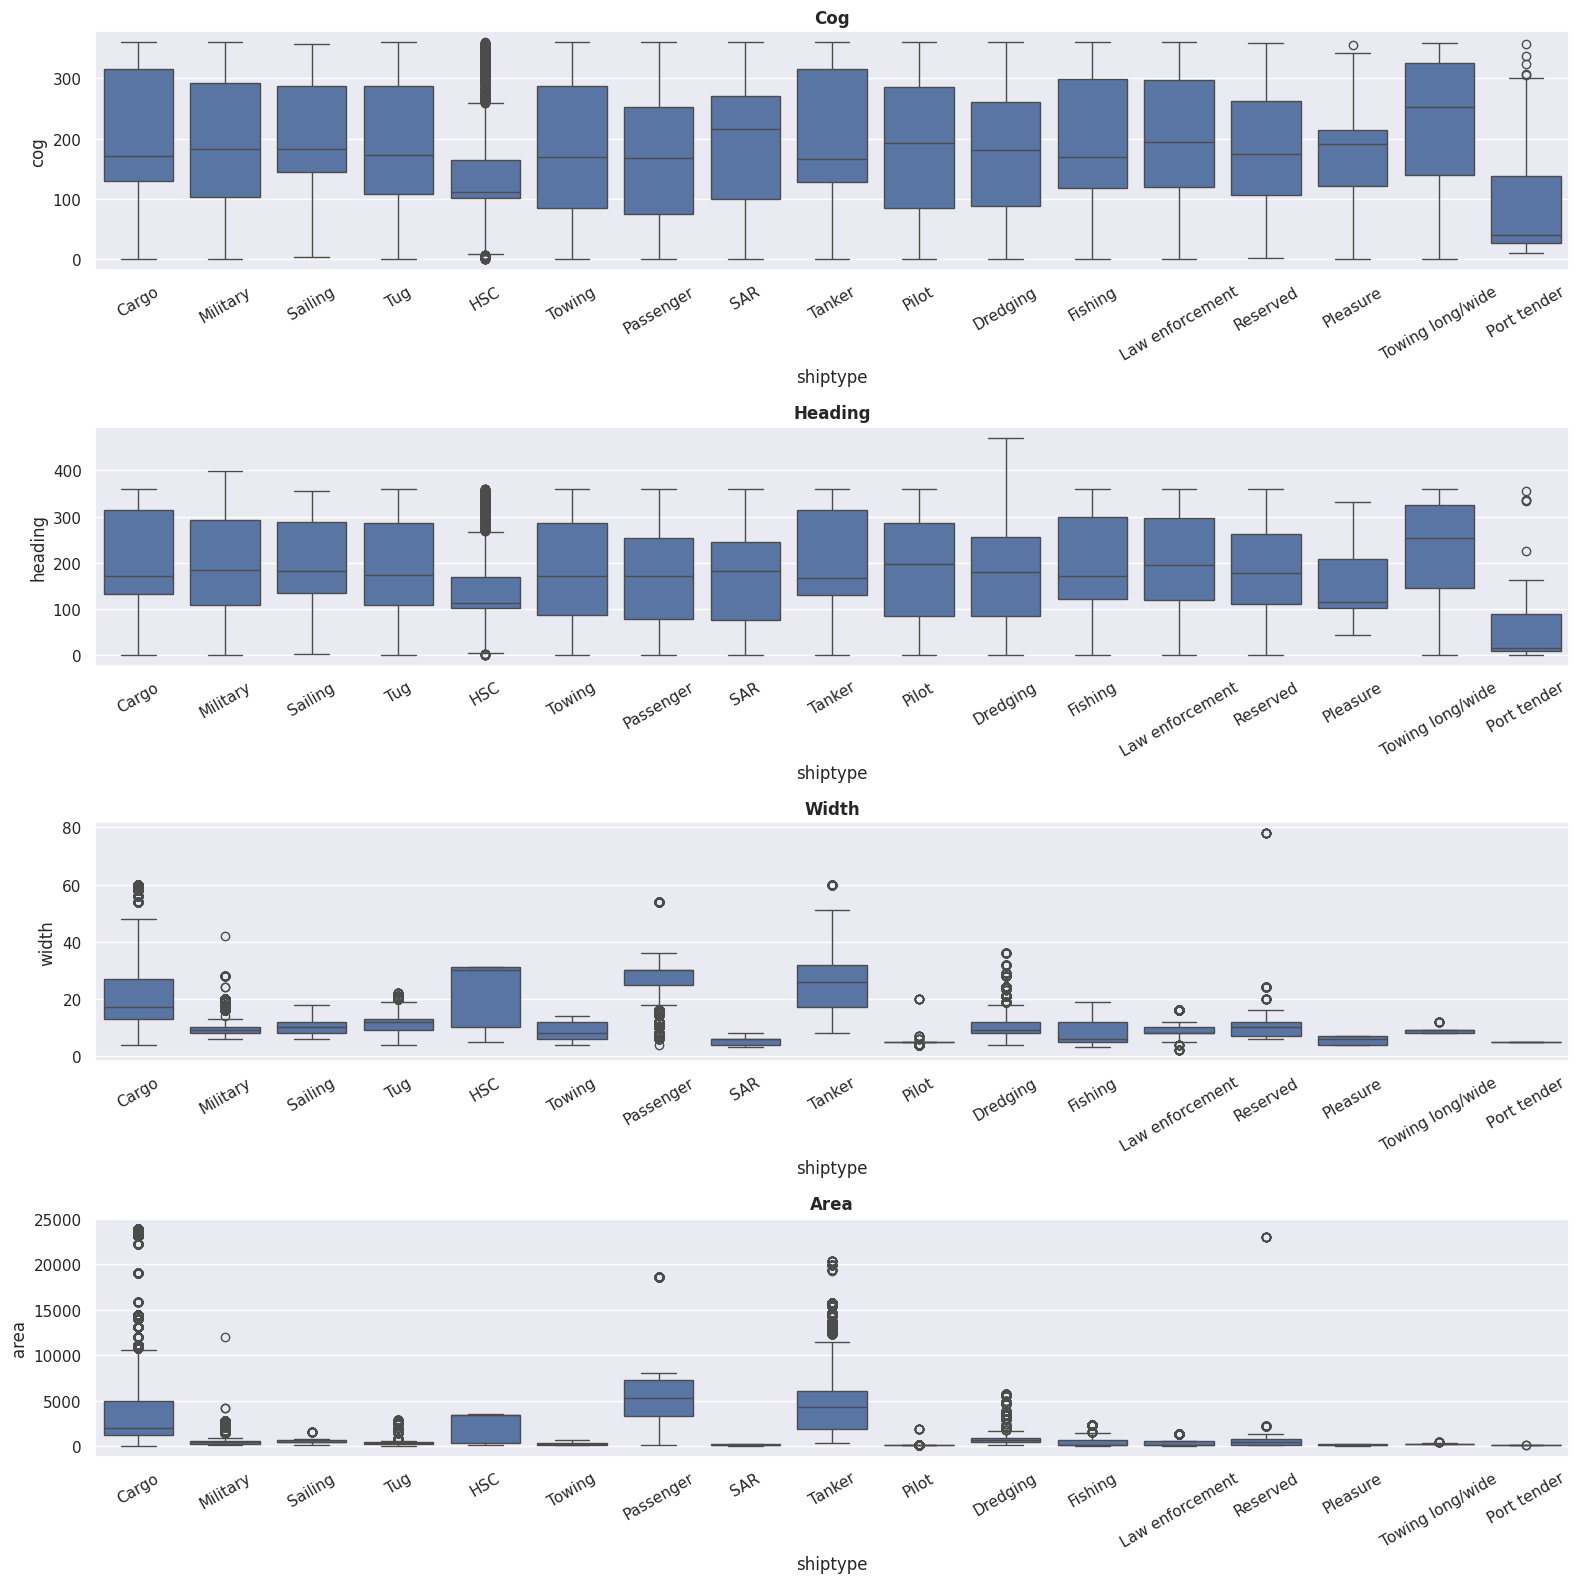

In [174]:
remaining_vars = ['cog', 'heading', 'width', 'area']

fig, axes = plt.subplots(4, 1, figsize=(16,16))


for i, col in enumerate(remaining_vars):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

It is clear from the above plots that width will be an important variable for the model(s), although there are some clear outliers shown in the Fishing and Pleasure ship types.
Cog appears to have the least variation between shiptypes with a median that does not seem to fluctuate much, however, the changes in the IQR show more of a fluctuation.

## Can we visualise clusters of ship type using PCA?

In [175]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

for_pca = df.dropna().sample(20000)

# Scale data
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(for_pca[numeric_cols]), columns=numeric_cols)

In [176]:
# PCA
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(scaled_df), 
             columns=[f'PCA{n+1}' for n in range(pca.fit_transform(scaled_df).shape[1])])

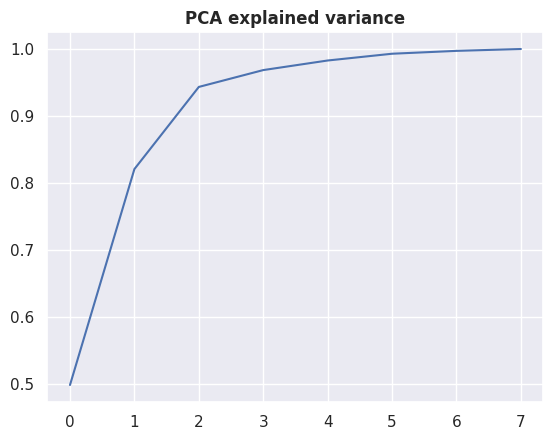

In [177]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA explained variance', weight='bold')
plt.show()

Plot shows that we are able to explain more than 90% of the variance using the first 2 components

In [178]:
pca_df_out = pd.concat([pca_df, for_pca['shiptype'].reset_index()], axis=1)

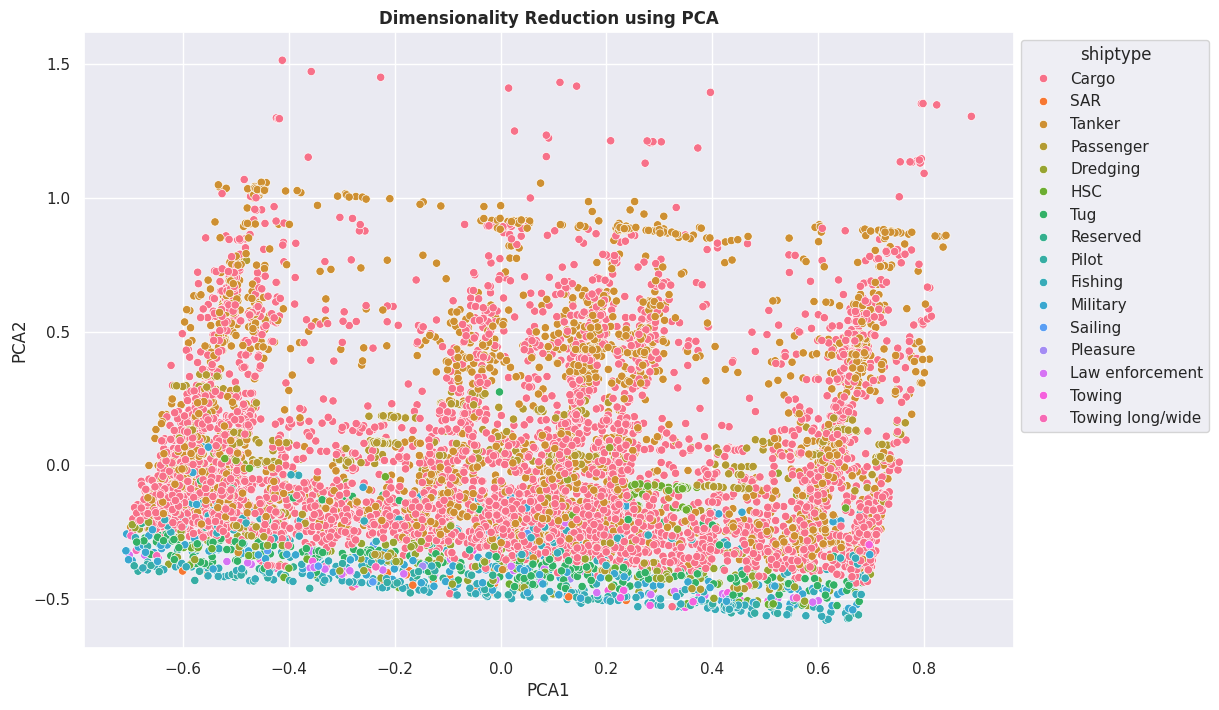

In [179]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=pca_df_out.sample(10000), x='PCA1', y='PCA2', hue='shiptype', legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Dimensionality Reduction using PCA', weight='bold')

plt.show()

We see some clusters along the x-axis, however too difficult to visualise with PCA

In [180]:
reducer = umap.UMAP()

In [181]:
umap_reduced = reducer.fit_transform(scaled_df)

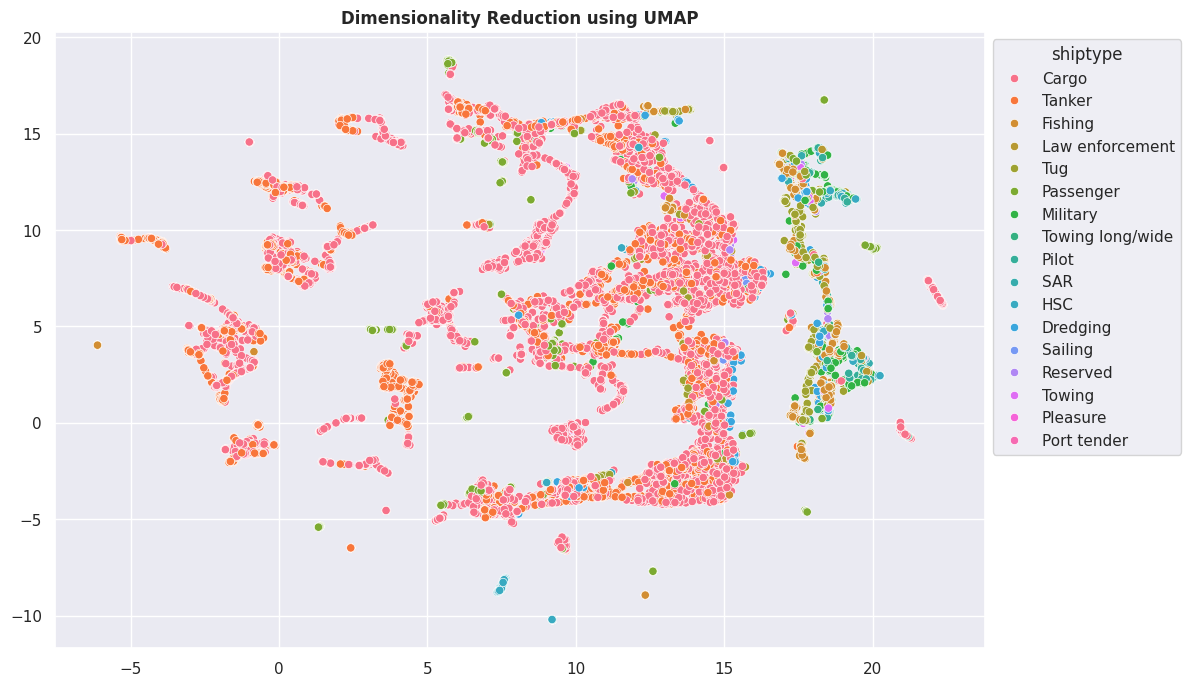

In [182]:
plt.figure(figsize=(12,8))

ax = sns.scatterplot(x=umap_reduced[:,0], y=umap_reduced[:,1], hue=for_pca.shiptype, legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Dimensionality Reduction using UMAP', weight='bold')

plt.show()

Better separation than PCA, but still difficult to derive any clear groups within these clusters with the exception of Tankers and Cargo.

## Model selection

The performance metric used to tune and validate the models will be balanced accuracy. The metric gives a better indication of model performance where the response variable classes are imbalanced. For example, if the model decided to predict every ship as Cargo, then the accuracy would be at almost 60% giving a miscomprehention of the model performance.

The steps in choosing the best model will be as follows:
- Train a number of classifiers using default hyperparameters.
- Select the best one or two models (depending on the results) using 5-fold cross validation.
- Tune this best model(s) using a number of different hyperparameters.
- Select best combination of hyperparameters. Re-train on the training data and test the model on the serving set. Note - it is important we also validate with this serving set as it has been completely left out of the tuning process and best represents that of a real-world scenario.

**It must also be noted that, I would typically train more models for step 1 as well as hyperparameter tuning on more combinations. However, given the time constraints, I have to reduce this somewhat.**

In [183]:
df.shiptype

4             Cargo
5             Cargo
7             Cargo
8             Cargo
11         Military
            ...    
358345       Tanker
358346        Cargo
358347        Cargo
358348    Passenger
358350      Fishing
Name: shiptype, Length: 324561, dtype: object

In [184]:
# Define the resposne variable
response = 'shiptype'

# One-hot encode thee categorical columns
cat_col = ['navigationalstatus']
dummies = pd.get_dummies(df[cat_col], dtype=int)
processed_df = pd.concat([df, dummies], axis=1).drop(cat_col, axis=1)

# Rename column with non-standard characters
processed_df = processed_df.rename(columns={'navigationalstatus_Reserved for future amendment [HSC]':'navigationalstatus_Reserved for future amendment'})

In [185]:
# Serving set to be kept completely left out of the cross validation and model tuning process to bee used as final validation.
np.random.seed(1)
mmsi_validation = np.random.choice(processed_df.mmsi.unique(), int(len(processed_df.mmsi.unique())*.1))

# Scale data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(processed_df.drop([response, 'mmsi'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=processed_df.drop([response, 'mmsi'], axis=1).columns)
scaled_df = pd.concat([scaled_df, processed_df[[response, 'mmsi']].reset_index(drop=True)], axis=1)

# Encode the response variable
encoder = LabelEncoder()
scaled_df['shiptype_encode'] = encoder.fit_transform(scaled_df[response])

# Split training and serving df
serving_df = scaled_df[scaled_df.mmsi.isin(mmsi_validation)]
train_df = scaled_df[~scaled_df.mmsi.isin(mmsi_validation)]



In [186]:
# Check we have representation between the classes
serving_df.shiptype.value_counts()

shiptype
Cargo               21876
Tanker               9310
Fishing               708
Dredging              673
Military              523
Pilot                 480
Passenger             271
Tug                   115
HSC                    82
Sailing                15
Towing long/wide        1
Name: count, dtype: int64

In [187]:
serving_df.shiptype_encode.value_counts()

shiptype_encode
0     21876
13     9310
2       708
1       673
5       523
7       480
6       271
16      115
3        82
12       15
15        1
Name: count, dtype: int64

In [188]:
response = 'shiptype_encode'
drop_cols = [response, 'mmsi', 'shiptype']

#Get bootstrap testing data by sampling with replacement
bootstrap_sampler = train_df.sample(len(train_df.index), replace=True)
X_test_bootstrap = bootstrap_sampler.drop(drop_cols, axis=1)
y_test_bootstrap = bootstrap_sampler[response]

X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

## Shortlist best model(s) - single split, out of box hyperparameters

In [189]:
## Split train and test
np.random.seed(1)
mmsi_test = np.random.choice(train_df.mmsi.unique(), int(len(train_df.mmsi.unique())*.2))

# Ensure train and test do not contain the same vessel
test = train_df[train_df.mmsi.isin(mmsi_test)]
train = train_df[~train_df.mmsi.isin(mmsi_test)]

X = train.drop(drop_cols, axis=1)
y = train[response]

X_test = test.drop(drop_cols, axis=1)
y_test = test[response]


In [190]:
# Define classifiers to test
classifiers = [
    RandomForestClassifier(),
    #MLPClassifier(),
    GradientBoostingClassifier(),
    #GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #xgb.XGBClassifier()
]

In [191]:
bal_acc_res = list()
acc_res = list()

# Train and log results for each of the classifiers
for mod in classifiers:
    t1 = time.time()
    
    try:
        print(f"Training classifier: {mod}")
        mod.fit(X, y)
        pred = mod.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, pred)
        acc = accuracy_score(y_test, pred)
        bal_acc_res.append(bal_acc)
        acc_res.append(acc)
        print(f"Balanced accuracy: {bal_acc}, accuracy: {acc}, time to train model: {time.time()-t1}")

    except Exception as e:
        print(e)
        print(f"Error in {mod}")


Training classifier: RandomForestClassifier()
Balanced accuracy: 0.5481736380214752, accuracy: 0.8484439191850977, time to train model: 17.76492476463318
Training classifier: GradientBoostingClassifier()
Balanced accuracy: 0.22341935400283844, accuracy: 0.06556362203838145, time to train model: 345.70879316329956


In [192]:
#Now to test using bootstrapping
bal_acc_res_bootstrap = list()
acc_res_bootstrap = list()
for mod in classifiers:
    t1 = time.time()
    try:
        print(f"Testing classifier with bootstrapping: {mod}")
        pred_bootstrap = mod.predict(X_test_bootstrap)
        bal_acc_bootstrap = balanced_accuracy_score(y_test_bootstrap, pred_bootstrap)
        acc_bootstrap = accuracy_score(y_test_bootstrap, pred_bootstrap)
        bal_acc_res_bootstrap.append(bal_acc_bootstrap)
        acc_res.append(acc)
        print(f"Balanced accuracy: {bal_acc_bootstrap}, accuracy: {acc_bootstrap}, time to train model: {time.time()-t1}")

    except Exception as e:
        print(e)
        print(f"Error in {mod}")

Testing classifier with bootstrapping: RandomForestClassifier()
Balanced accuracy: 0.9310995610335976, accuracy: 0.9724860330387908, time to train model: 3.909222364425659
Testing classifier with bootstrapping: GradientBoostingClassifier()
Balanced accuracy: 0.4672671609471621, accuracy: 0.09010109911293016, time to train model: 4.974612236022949


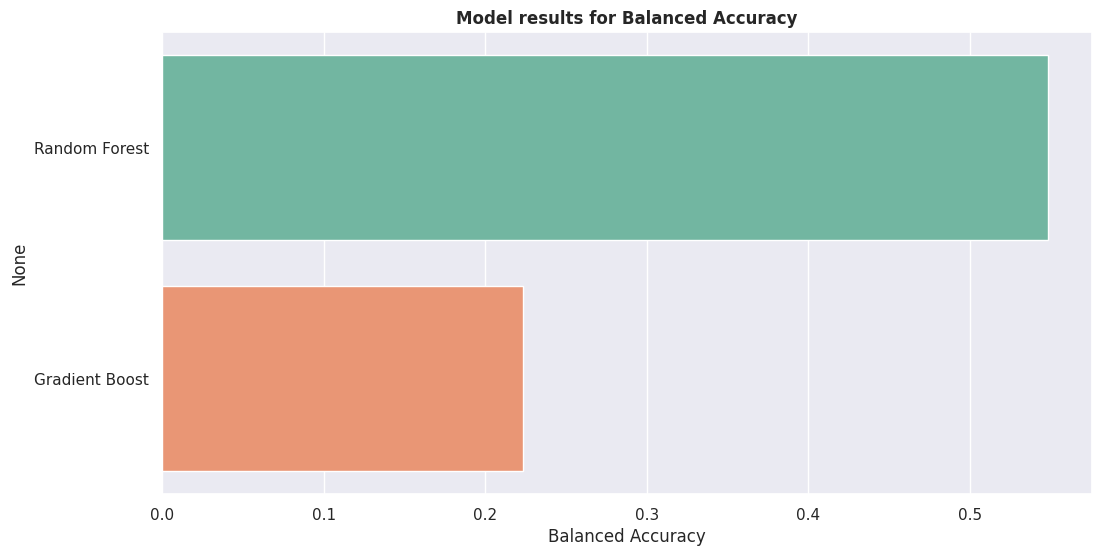

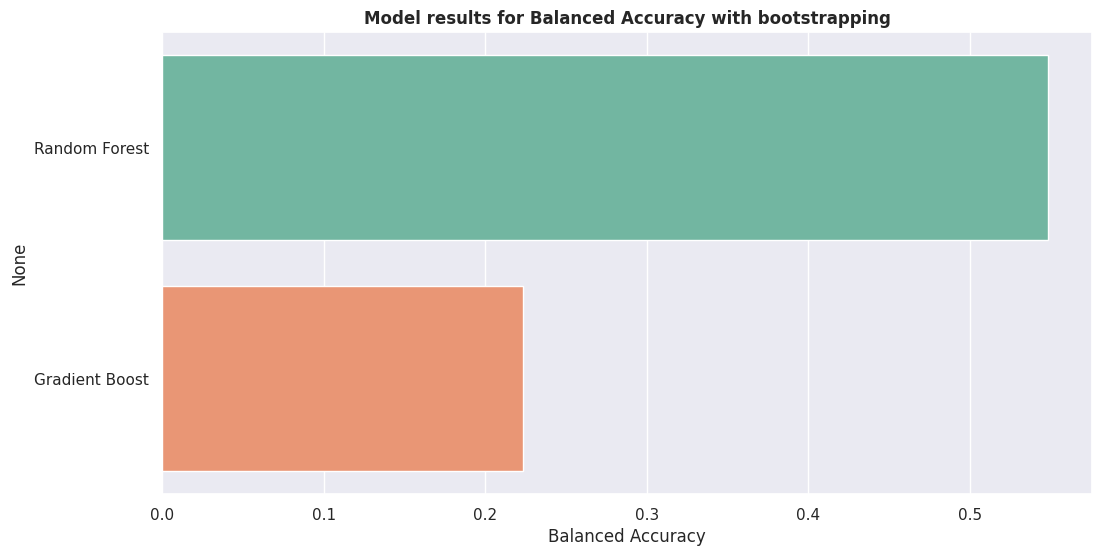

In [193]:
names = [
    'Random Forest',
    #'MLP',
    'Gradient Boost',
    #'Gaussian NB',
    #'LDA',
    #'XGB'
]

results = pd.DataFrame(bal_acc_res, index=names)

results = results.set_axis(['Balanced Accuracy'], axis=1, copy=False).sort_values(by='Balanced Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Balanced Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Balanced Accuracy', weight='bold')

plt.show()


results_bootstrap = pd.DataFrame(bal_acc_res_bootstrap, index=names)

results_bootstrap = results.set_axis(['Balanced Accuracy'], axis=1, copy=False).sort_values(by='Balanced Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results_bootstrap['Balanced Accuracy'], y=results_bootstrap.index, palette='Set2')
plt.title('Model results for Balanced Accuracy with bootstrapping', weight='bold')

plt.show()

The out of box results show Random forest having both highest balanced accuracy (approx. 55%) and accuracy (approx. 85%)

## Tune best model

In [194]:
# Define model hyperparameter function
def tune_best_model(train_df: pd.DataFrame, 
                    params: dict[str, Any],
                    drop_cols: list[str],
                    response: str = 'shiptype_encode', 
                    group: str = 'mmsi',
                    scoring_metric: str = 'balanced_accuracy') -> dict[str, Any]:
    """Function to tune model and return best results and params

    Args:
        train_df (pd.DataFrame): Training data
        params (dict[str, Any]): Parameters to tune
        drop_cols (list[str]): Columns to drop
        response (str, optional): Response variable. Defaults to 'shiptype_encode'.
        group (str, optional): Variable to use for the grouped k-fold. 
        Defaults to 'mmsi'.
        scoring_metric (str, optional): Performance metric. Defaults to 'balanced_accuracy'.

    Returns:
        dict[str, Any]: results dictionary
    """    

    # Define groups for group k-fold
    groups = train_df[group]

    X = train_df.drop(drop_cols, axis=1)
    y = train_df[response]

    # Grouped 5-fold CV
    gkf = GroupKFold(n_splits=5)
    gkf.get_n_splits(X, y, groups)

    print(f"Tuning models for {response} with {len(train_df)} training rows")

    # Define sample weights since we are dealing with a significant imbalance between classes
    samp_weights = compute_sample_weight(class_weight='balanced', y=y)

    rf_cv = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=params,
        cv=gkf,
        verbose=10,
        scoring=scoring_metric,
    )

    rf_cv.fit(X, y, groups=groups, sample_weight=samp_weights)

    results = dict(
        {
            f"scores_{response}": rf_cv.best_score_,
            f"params_{response}": rf_cv.best_params_
        }
    )

    return results

In [195]:
params = {'max_depth': [None, 4,5,6, 7, 8, 9, 10],
         'n_estimators': [50, 100, 200]}

results = tune_best_model(train_df, params=params, drop_cols=drop_cols)

Tuning models for shiptype_encode with 290507 training rows
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 1/5; 1/24] END max_depth=None, n_estimators=50;, score=0.566 total time=   8.4s
[CV 2/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 2/5; 1/24] END max_depth=None, n_estimators=50;, score=0.458 total time=   8.5s
[CV 3/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 3/5; 1/24] END max_depth=None, n_estimators=50;, score=0.511 total time=   8.7s
[CV 4/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 4/5; 1/24] END max_depth=None, n_estimators=50;, score=0.384 total time=   8.4s
[CV 5/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 5/5; 1/24] END max_depth=None, n_estimators=50;, score=0.448 total time=   8.7s
[CV 1/5; 2/24] START max_depth=None, n_estimators=100

Cross validation score with hyperparameters max depth:9 and n estimators:50 = Balanced accuracy 48.3%

## Evaluate model with best hyperparameters on serving set

In [196]:
best_params = {'max_depth': 9, 'n_estimators': 50}

In [197]:
X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

samp_weights = compute_sample_weight(class_weight='balanced', y=y)
mod = RandomForestClassifier(**best_params)
mod.fit(X, y, samp_weights)

RandomForestClassifier(max_depth=9, n_estimators=50)

In [198]:
X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

In [199]:
preds = mod.predict(X_serving)

In [200]:
probs = mod.predict_proba(X_serving)

In [201]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.6440139301055928, accuraqcy=0.634697832853703


In [202]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.6440139301055928, accuraqcy=0.634697832853703


# Creating a tuned Gradient Boosting model with lightgbm and Optuna

In [203]:
#Now to see what we can't find out with lightgbm
import lightgbm
import optuna

accuracies = []
n_estimators_over_time=[]
max_depth_over_time=[]
def train_classifier(trial):
    n_estimators = trial.suggest_int("n_estimators", low = 1, high=100)
    max_depth = trial.suggest_int("max_depth", low = 2, high=100)

    classifier = lightgbm.LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, verbose=-100)
    classifier.fit(X, y)
    y_pred = classifier.predict(X_test)
 
    accuracy = accuracy_score(y_pred, y_test)
    accuracies.append(accuracy)
    n_estimators_over_time.append(n_estimators)
    max_depth_over_time.append(max_depth)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(train_classifier, n_trials=100)


[I 2023-10-08 05:04:05,100] A new study created in memory with name: no-name-659d5960-cfb0-4b9d-9ace-b3636c6d9a7f
[I 2023-10-08 05:04:07,727] Trial 0 finished with value: 0.7133772300073161 and parameters: {'n_estimators': 59, 'max_depth': 17}. Best is trial 0 with value: 0.7133772300073161.
[I 2023-10-08 05:04:08,800] Trial 1 finished with value: 0.8890577222503612 and parameters: {'n_estimators': 27, 'max_depth': 53}. Best is trial 1 with value: 0.8890577222503612.
[I 2023-10-08 05:04:10,899] Trial 2 finished with value: 0.836888213555443 and parameters: {'n_estimators': 51, 'max_depth': 47}. Best is trial 1 with value: 0.8890577222503612.
[I 2023-10-08 05:04:13,698] Trial 3 finished with value: 0.6889714296433864 and parameters: {'n_estimators': 63, 'max_depth': 71}. Best is trial 1 with value: 0.8890577222503612.
[I 2023-10-08 05:04:14,770] Trial 4 finished with value: 0.8964301123679816 and parameters: {'n_estimators': 27, 'max_depth': 52}. Best is trial 4 with value: 0.8964301123

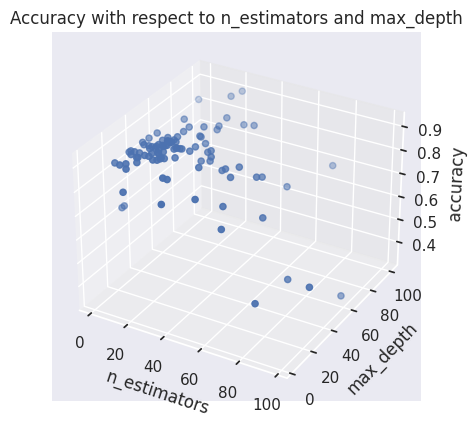

Best parameters:
{'n_estimators': 21, 'max_depth': 42}
Best value:
0.9171215787795224
Testing tuned gradient boosting model on serving data
Accuracy:
0.8571973923768132


In [204]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(n_estimators_over_time, max_depth_over_time, accuracies)

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('accuracy')
plt.title("Accuracy with respect to n_estimators and max_depth")
plt.show()

print("Best parameters:")
print(study.best_params)
print("Best value:")
print(study.best_value)

print("Testing tuned gradient boosting model on serving data")

classifier = lightgbm.LGBMClassifier(n_estimators=study.best_params['n_estimators'], max_depth=study.best_params['max_depth'], verbose=-100)
classifier.fit(X, y)
y_pred = classifier.predict(X_serving)
accuracy = accuracy_score(y_serving,y_pred)
print("Accuracy:")
print(accuracy)

## Feature Importance

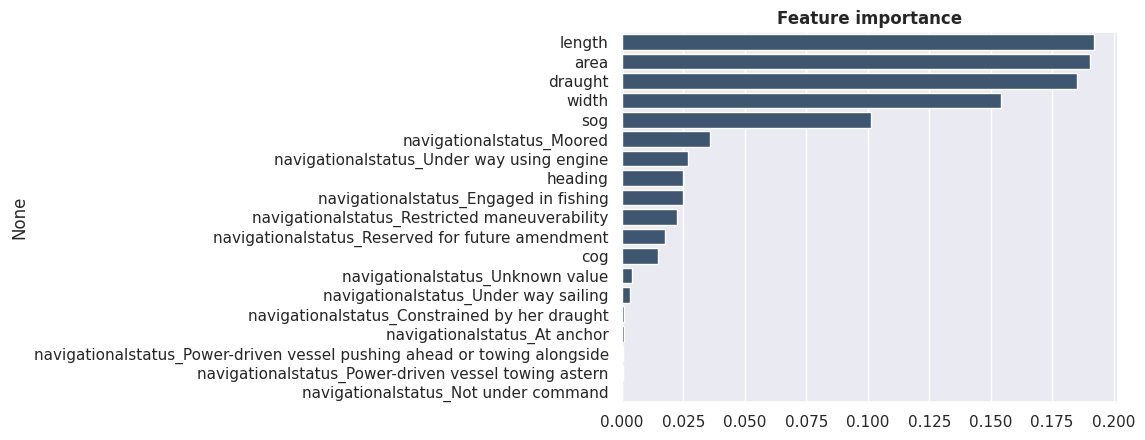

In [205]:
# Extract feature importance
feat_imp = pd.Series(mod.feature_importances_, X.columns).sort_values(
    ascending=False
)
# # Remove columns which provide no benefit to the model
# feat_imp = feat_imp[feat_imp > 0.01]
feat_df = pd.DataFrame(feat_imp.values, feat_imp.index)

sns.barplot(x=feat_imp.values, y=feat_imp.index, color="#375578")
plt.title(f"Feature importance", weight="bold")
plt.show()

> ## Additional validation is to understand how confident the model is predicting the classes

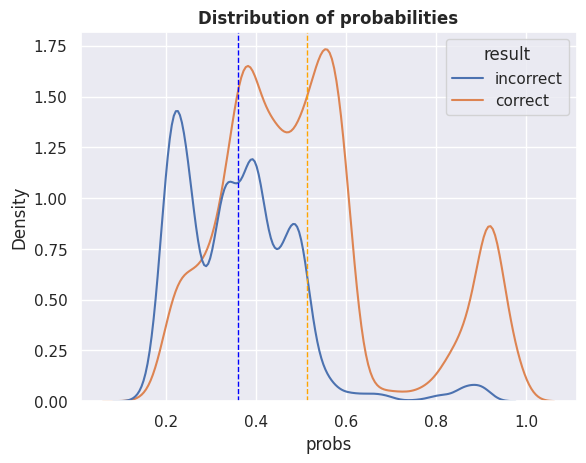

In [206]:
results_df = pd.DataFrame(
            {
                "ground_truth": serving_df[response],
                "ground_truth_orig": serving_df['shiptype'],
                "pred": preds,
                "probs": [prob[pred] for (pred, prob) in zip(preds, probs)]
            }
        )

results_df['result'] = results_df.apply(lambda x: 'correct' if x.ground_truth==x.pred else 'incorrect', axis=1)

sns.kdeplot(data=results_df, x="probs", hue='result')
plt.axvline(results_df[results_df.result=='correct'].probs.mean(), c="orange", ls="--", lw=1)
plt.axvline(results_df[results_df.result=='incorrect'].probs.mean(), c="blue", ls="--", lw=1)
plt.title("Distribution of probabilities", weight="bold")
plt.show()

The above probability plot illustrates the distribution of probabilities for the predictions the model gets correct compared to the predictions it makes that are incorrect. The model is both predicting with high confidence as well as showing a significant difference between the ones it gets correct opposed to what it gets incorrect.

## Lastly, get results for each class

In [207]:
acc_list = list()

for ship in results_df.ground_truth_orig.unique():
    ship_res = results_df[results_df.ground_truth_orig==ship]
    acc = accuracy_score(ship_res.ground_truth, ship_res.pred)
    acc_list.append(acc)

    print(f"Results for {ship}, accuracy:{round(acc, 2)}, count:{len(ship_res)}")



Results for Cargo, accuracy:0.59, count:21876
Results for Military, accuracy:0.3, count:523
Results for Tanker, accuracy:0.72, count:9310
Results for HSC, accuracy:0.59, count:82
Results for Pilot, accuracy:1.0, count:480
Results for Passenger, accuracy:0.89, count:271
Results for Dredging, accuracy:0.9, count:673
Results for Fishing, accuracy:0.75, count:708
Results for Towing long/wide, accuracy:1.0, count:1
Results for Tug, accuracy:0.37, count:115
Results for Sailing, accuracy:0.0, count:15


In [208]:
results

{'scores_shiptype_encode': 0.5125465927816126,
 'params_shiptype_encode': {'max_depth': 10, 'n_estimators': 100}}

In [209]:
df

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,1287.0
5,636020662,At anchor,0.1,43.9,286.0,Cargo,23.0,149.0,6.3,3427.0
7,246539000,At anchor,0.0,3.8,293.0,Cargo,16.0,150.0,6.8,2400.0
8,210307000,Moored,0.0,285.1,225.0,Cargo,16.0,90.0,5.2,1440.0
11,219263000,Moored,0.0,353.9,100.0,Military,12.0,48.0,4.2,576.0
...,...,...,...,...,...,...,...,...,...,...
358345,266475000,Under way using engine,11.2,92.4,90.0,Tanker,17.0,120.0,6.7,2040.0
358346,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2,984.0
358347,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9,4590.0
358348,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9,8064.0


In [210]:
results = pd.DataFrame(acc_list, index=results_df.ground_truth_orig.unique())
results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

count_all = list()
count_serving = list()

for ship in results.index:
    count_all.append(len(df[df.shiptype==ship]))
    count_serving.append(len(results_df[results_df.ground_truth_orig==ship]))

results['count_all'] = count_all
results['count_serving'] = count_serving

results

,Accuracy,count_all,count_serving
Pilot,1.000000,2902,480
Towing long/wide,1.000000,586,1
Dredging,0.897474,5109,673
Passenger,0.885609,16778,271
Fishing,0.745763,12110,708
Tanker,0.721375,77405,9310
HSC,0.585366,3694,82
Cargo,0.585070,186699,21876
Tug,0.365217,9410,115
Military,0.298279,6073,523


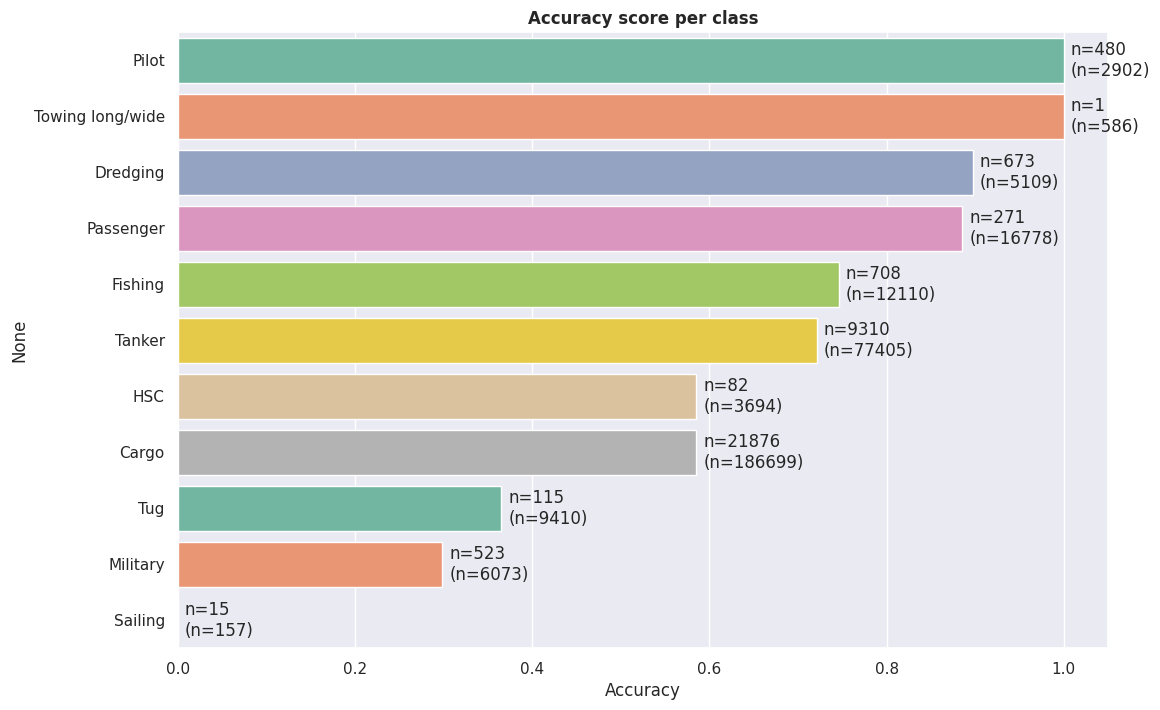

In [211]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')

for p, count, count_train in zip(ax.patches, results.count_serving,results.count_all):
    ax.annotate(f"n={count}\n(n={count_train})", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.title('Accuracy score per class', weight='bold')

plt.show()